In [ ]:
!pip install pandas scikit-learn matplotlib seaborn

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/archive.zip" -d "/content/drive/MyDrive/Data"

Archive:  /content/drive/MyDrive/archive.zip
replace /content/drive/MyDrive/Data/1.benign.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: /content/drive/MyDrive/Data/README.md  
  inflating: /content/drive/MyDrive/Data/data_summary.csv  
  inflating: /content/drive/MyDrive/Data/device_info.csv  
  inflating: /content/drive/MyDrive/Data/features.csv  


In [ ]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import glob
import os
import re

In [ ]:
device_map = {
    "1": "Danmini_Doorbell",
    "2": "Ecobee_Thermostat",
    "3": "Ennio_Doorbell",
    "4": "Philips_B120N10_Baby_Monitor",
    "5": "Provision_PT_737E_Security_Camera",
    "6": "Provision_PT_838_Security_Camera",
    "7": "Samsung_SNH_1011_N_Webcam",
    "8": "SimpleHome_1002_Camera",
    "9": "SimpleHome_1003_Hub"
}

In [ ]:
output_file = "/content/drive/MyDrive/Data/NBAIoT_LABELED.parquet"

if os.path.exists(output_file):
    os.remove(output_file)

writer = None

In [ ]:
csv_files = glob.glob("/content/drive/MyDrive/Data/*.csv")
print("Total CSV files:", len(csv_files))

Total CSV files: 89


In [ ]:
for f in csv_files:

    name = os.path.basename(f)


    device_id = name.split(".")[0]
    device_name = device_map.get(device_id, "Unknown_Device")

    attack_type = ".".join(name.split(".")[1:]).replace(".csv","")


    print(f"Processing {name}  →  {device_name} / {attack_type}")

    # CHUNKED PROCESSING
    for chunk in pd.read_csv(f, chunksize=200_000, low_memory=True):

        # adding labels
        chunk["device_id"] = device_id
        chunk["device_name"] = device_name
        chunk["attack_type"] = attack_type

        # converting to Arrow table
        table = pa.Table.from_pandas(chunk, preserve_index=False)

        if writer is None:
            writer = pq.ParquetWriter(output_file, table.schema)

        writer.write_table(table)


if writer:
    writer.close()

print("MERGE + LABELING COMPLETED.")

Processing 1.benign.csv  →  Danmini_Doorbell / benign
Processing 1.gafgyt.combo.csv  →  Danmini_Doorbell / gafgyt.combo
Processing 1.gafgyt.junk.csv  →  Danmini_Doorbell / gafgyt.junk
Processing 1.gafgyt.scan.csv  →  Danmini_Doorbell / gafgyt.scan
Processing 1.gafgyt.tcp.csv  →  Danmini_Doorbell / gafgyt.tcp
Processing 1.gafgyt.udp.csv  →  Danmini_Doorbell / gafgyt.udp
Processing 1.mirai.ack.csv  →  Danmini_Doorbell / mirai.ack
Processing 1.mirai.scan.csv  →  Danmini_Doorbell / mirai.scan
Processing 1.mirai.syn.csv  →  Danmini_Doorbell / mirai.syn
Processing 1.mirai.udp.csv  →  Danmini_Doorbell / mirai.udp
Processing 1.mirai.udpplain.csv  →  Danmini_Doorbell / mirai.udpplain
Processing 2.benign.csv  →  Ecobee_Thermostat / benign
Processing 2.gafgyt.combo.csv  →  Ecobee_Thermostat / gafgyt.combo
Processing 2.gafgyt.junk.csv  →  Ecobee_Thermostat / gafgyt.junk
Processing 2.gafgyt.scan.csv  →  Ecobee_Thermostat / gafgyt.scan
Processing 2.gafgyt.tcp.csv  →  Ecobee_Thermostat / gafgyt.tcp
P

In [ ]:
# ==============================
# DATA STATS BEFORE CLEANING
# ==============================

import pyarrow.parquet as pq
import numpy as np
import pandas as pd

pf = pq.ParquetFile(output_file)

nan_before = 0
inf_before = 0
total_values = 0

for batch in pf.iter_batches(batch_size=200_000):
    df = batch.to_pandas()
    num_df = df.select_dtypes(include=[np.number])

    nan_before += num_df.isna().sum().sum()
    inf_before += np.isinf(num_df).sum().sum()
    total_values += num_df.size

affected_pct = round((nan_before + inf_before) * 100 / total_values, 6)

cleaning_stats = pd.DataFrame({
    "Stage": ["Before Cleaning"],
    "NaN_Count": [nan_before],
    "Inf_Count": [inf_before],
    "Affected_%": [affected_pct]
})

cleaning_stats


,Stage,NaN_Count,Inf_Count,Affected_%
0,Before Cleaning,0,0,0.0


In [ ]:
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np

source = output_file
clean_file = "/content/cleaned_nbaiot.parquet"

clean_writer = None

parquet_file = pq.ParquetFile(source)

for batch in parquet_file.iter_batches(batch_size=200_000):

    df = batch.to_pandas()


    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    table = pa.Table.from_pandas(df, preserve_index=False)

    if clean_writer is None:
        clean_writer = pq.ParquetWriter(clean_file, table.schema)

    clean_writer.write_table(table)

if clean_writer:
    clean_writer.close()

print("CLEANING DONE.")

CLEANING DONE.


In [ ]:
# ==============================
# DATA STATS AFTER CLEANING
# ==============================

pf_clean = pq.ParquetFile(clean_file)

nan_after = 0
inf_after = 0

for batch in pf_clean.iter_batches(batch_size=200_000):
    df = batch.to_pandas()
    num_df = df.select_dtypes(include=[np.number])

    nan_after += num_df.isna().sum().sum()
    inf_after += np.isinf(num_df).sum().sum()

cleaning_stats_after = pd.DataFrame({
    "Stage": ["After Cleaning"],
    "NaN_Count": [nan_after],
    "Inf_Count": [inf_after],
    "Affected_%": [0.0]
})

pd.concat([cleaning_stats, cleaning_stats_after])


,Stage,NaN_Count,Inf_Count,Affected_%
0,Before Cleaning,0,0,0.0
0,After Cleaning,0,0,0.0


In [ ]:
cleaning_stats = pd.DataFrame({
    "Stage": ["Before Cleaning", "After Cleaning"],
    "NaN_Count": [nan_before, 0],
    "Inf_Count": [inf_before, 0],
    "Affected_%": [affected_pct, 0.0]
})
cleaning_stats.to_csv("cleaning_stats.csv", index=False)

In [ ]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np

# ================================
# CONFIG
# ================================
clean_file = "/content/cleaned_nbaiot.parquet"   # adjust if different
train_file = "/content/train_nbaiot.parquet"
test_file  = "/content/test_nbaiot.parquet"

batch_size   = 200_000
train_ratio  = 0.8
rng          = np.random.RandomState(42)

# Open once to get base schema (without is_attack)
pf = pq.ParquetFile(clean_file)

base_arrow_schema = pf.schema.to_arrow_schema()


schema_with_attack = base_arrow_schema.append(pa.field("is_attack", pa.int64()))
all_cols = list(base_arrow_schema.names) + ["is_attack"]

# ================================
# PASS 1: COUNT BINARY LABELS GLOBALLY
# ================================
total_counts = {0: 0, 1: 0}
print("PASS 1: Counting benign vs attack globally...")

for batch in pf.iter_batches(batch_size=batch_size, columns=None):
    df = batch.to_pandas()

    if "is_attack" in df.columns:
        labels = df["is_attack"].astype(int).to_numpy()
    elif "attack_type" in df.columns:
        labels = (df["attack_type"] != "benign").astype(int).to_numpy()
    else:
        raise ValueError("Need either 'is_attack' or 'attack_type' column.")

    unique, counts = np.unique(labels, return_counts=True)
    for u, c in zip(unique, counts):
        total_counts[int(u)] += int(c)

print("Total counts:", total_counts)

train_target = {c: int(round(total_counts[c] * train_ratio)) for c in (0, 1)}
train_remaining = train_target.copy()

print("Target train counts (≈80%):", train_target)
print("Initial remaining train quotas:", train_remaining)

# ================================
# PASS 2: STREAM + ASSIGN TO TRAIN/TEST GLOBALLY
# ================================
print("\nPASS 2: Writing stratified train/test parquet in batches...")

# Re-open ParquetFile for second pass
pf = pq.ParquetFile(clean_file)


train_writer = pq.ParquetWriter(train_file, schema_with_attack)
test_writer  = pq.ParquetWriter(test_file,  schema_with_attack)

for batch in pf.iter_batches(batch_size=batch_size, columns=None):
    df = batch.to_pandas()

    # Ensure binary label exists
    if "is_attack" in df.columns:
        df["is_attack"] = df["is_attack"].astype(int)
    elif "attack_type" in df.columns:
        df["is_attack"] = (df["attack_type"] != "benign").astype(int)
    else:
        raise ValueError("Need either 'is_attack' or 'attack_type' column.")

    labels = df["is_attack"].to_numpy()
    n = len(df)
    train_mask = np.zeros(n, dtype=bool)

    # Allocate per class (0 = benign, 1 = attack)
    for c in (0, 1):
        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            continue

        rng.shuffle(idx)

        need_train = max(train_remaining[c], 0)
        take_train = min(need_train, len(idx))

        if take_train > 0:
            chosen = idx[:take_train]
            train_mask[chosen] = True
            train_remaining[c] -= take_train

    # Split into train/test DataFrames
    train_df = df[train_mask].copy()
    test_df  = df[~train_mask].copy()

    # Ensure column order and presence matches schema
    train_df = train_df[all_cols]
    test_df  = test_df[all_cols]

    # Convert using the fixed schema
    t_train = pa.Table.from_pandas(train_df, schema=schema_with_attack, preserve_index=False)
    t_test  = pa.Table.from_pandas(test_df,  schema=schema_with_attack, preserve_index=False)

    # Write to parquet
    if t_train.num_rows > 0:
        train_writer.write_table(t_train)
    if t_test.num_rows > 0:
        test_writer.write_table(t_test)

# Close writers
train_writer.close()
test_writer.close()

print("\nGLOBAL BINARY STRATIFIED TRAIN–TEST SPLIT DONE.")
print("Remaining train quotas (should be small or zero):", train_remaining)
print("Train file:", train_file)
print("Test  file:", test_file)


PASS 1: Counting benign vs attack globally...
Total counts: {0: 555932, 1: 6506674}
Target train counts (≈80%): {0: 444746, 1: 5205339}
Initial remaining train quotas: {0: 444746, 1: 5205339}

PASS 2: Writing stratified train/test parquet in batches...

GLOBAL BINARY STRATIFIED TRAIN–TEST SPLIT DONE.
Remaining train quotas (should be small or zero): {0: 0, 1: 0}
Train file: /content/train_nbaiot.parquet
Test  file: /content/test_nbaiot.parquet


In [ ]:
import pyarrow.parquet as pq
import numpy as np

train_file = "/content/train_nbaiot.parquet"
test_file  = "/content/test_nbaiot.parquet"

def get_is_attack_ratio(parquet_path, batch_size=200_000):
    pf = pq.ParquetFile(parquet_path)

    counts = {0: 0, 1: 0}

    # Stream only the 'is_attack' column, batch by batch
    for batch in pf.iter_batches(batch_size=batch_size, columns=["is_attack"]):
        col = batch.column("is_attack")
        arr = col.to_numpy(zero_copy_only=False)
        arr = arr[np.isin(arr, [0, 1])]

        unique, cts = np.unique(arr, return_counts=True)
        for u, ct in zip(unique, cts):
            counts[int(u)] += int(ct)

    total = counts[0] + counts[1]
    if total == 0:
        return counts, {"0": 0.0, "1": 0.0}

    ratios = {
        "0 (benign)": counts[0] / total,
        "1 (attack)": counts[1] / total,
    }
    return counts, ratios

train_counts, train_ratios = get_is_attack_ratio(train_file)
test_counts,  test_ratios  = get_is_attack_ratio(test_file)

print("Train counts:", train_counts)
print("Train ratios:", train_ratios)

print("\nTest counts:", test_counts)
print("Test ratios:", test_ratios)


Train counts: {0: 444746, 1: 5205339}
Train ratios: {'0 (benign)': 0.0787149219878993, '1 (attack)': 0.9212850780121007}

Test counts: {0: 111186, 1: 1301335}
Test ratios: {'0 (benign)': 0.07871458194249856, '1 (attack)': 0.9212854180575014}


In [ ]:

train_file = "/content/train_nbaiot.parquet"
train = pq.ParquetFile(train_file)

In [ ]:
total_rows = 0
cols = None

for batch in train.iter_batches(batch_size=200_000):
    df = batch.to_pandas()
    total_rows += len(df)
    if cols is None:
        cols = df.columns

print("Total rows:", total_rows)
print("Total columns:", len(cols))
print("Columns:", list(cols))

Total rows: 5650085
Total columns: 119
Columns: ['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance', 'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance', 'MI_dir_L0.1_weight', 'MI_dir_L0.1_mean', 'MI_dir_L0.1_variance', 'MI_dir_L0.01_weight', 'MI_dir_L0.01_mean', 'MI_dir_L0.01_variance', 'H_L5_weight', 'H_L5_mean', 'H_L5_variance', 'H_L3_weight', 'H_L3_mean', 'H_L3_variance', 'H_L1_weight', 'H_L1_mean', 'H_L1_variance', 'H_L0.1_weight', 'H_L0.1_mean', 'H_L0.1_variance', 'H_L0.01_weight', 'H_L0.01_mean', 'H_L0.01_variance', 'HH_L5_weight', 'HH_L5_mean', 'HH_L5_std', 'HH_L5_magnitude', 'HH_L5_radius', 'HH_L5_covariance', 'HH_L5_pcc', 'HH_L3_weight', 'HH_L3_mean', 'HH_L3_std', 'HH_L3_magnitude', 'HH_L3_radius', 'HH_L3_covariance', 'HH_L3_pcc', 'HH_L1_weight', 'HH_L1_mean', 'HH_L1_std', 'HH_L1_magnitude', 'HH_L1_radius', 'HH_L1_covariance', 'HH_L1_pcc', 'HH_L0.1_weight', 'HH_L0.1_mean', 'HH_L0.1_std', 'HH_L0.1_magni

In [ ]:
import numpy as np
import pandas as pd

missing_counts = None

for batch in train.iter_batches(batch_size=200_000):
    df = batch.to_pandas()
    batch_missing = df.isnull().sum()

    if missing_counts is None:
        missing_counts = batch_missing
    else:
        missing_counts += batch_missing

print("Missing values per column:\n")
print(missing_counts)

Missing values per column:

MI_dir_L5_weight      0
MI_dir_L5_mean        0
MI_dir_L5_variance    0
MI_dir_L3_weight      0
MI_dir_L3_mean        0
                     ..
HpHp_L0.01_pcc        0
device_id             0
device_name           0
attack_type           0
is_attack             0
Length: 119, dtype: int64


In [ ]:
batch = next(train.iter_batches(batch_size=20_000))
df = batch.to_pandas()
print(df.dtypes)

MI_dir_L5_weight      float64
MI_dir_L5_mean        float64
MI_dir_L5_variance    float64
MI_dir_L3_weight      float64
MI_dir_L3_mean        float64
                       ...   
HpHp_L0.01_pcc        float64
device_id              object
device_name            object
attack_type            object
is_attack               int64
Length: 119, dtype: object


In [ ]:
seen = set()
dups = 0

batch = next(train.iter_batches(batch_size=50_000))
df = batch.to_pandas()

for row in df.itertuples(index=False):
    if row in seen:
        dups += 1
    else:
        seen.add(row)

print("Approx duplicate rows in sample:", dups)

Approx duplicate rows in sample: 9153


In [ ]:
from collections import Counter
attack_counter = Counter()

for batch in train.iter_batches(batch_size=200_000):
    df = batch.to_pandas()
    attack_counter.update(df["attack_type"])

print("Attack type distribution:\n")
print(attack_counter)

Attack type distribution:

Counter({'mirai.udp': 921036, 'gafgyt.udp': 814758, 'gafgyt.tcp': 761775, 'mirai.ack': 496993, 'mirai.syn': 485105, 'gafgyt.combo': 455758, 'mirai.scan': 448375, 'benign': 444746, 'mirai.udpplain': 360624, 'gafgyt.junk': 234376, 'gafgyt.scan': 226539})


In [ ]:
benign = 0
attack = 0

for batch in train.iter_batches(batch_size=200_000):
    df = batch.to_pandas()
    benign += (df["attack_type"] == "benign").sum()
    attack += (df["attack_type"] != "benign").sum()

print("Benign count:", benign)
print("Attack count:", attack)
print("Benign ratio:", benign / (benign + attack))

Benign count: 444746
Attack count: 5205339
Benign ratio: 0.0787149219878993


In [ ]:
device_attack_map = {}

for batch in train.iter_batches(batch_size=200_000):
    df = batch.to_pandas()
    for device, attack_type in zip(df["device_name"], df["attack_type"]):
        key = (device, attack_type)
        device_attack_map[key] = device_attack_map.get(key, 0) + 1

print("Device-wise attack type counts:\n")
for k, v in device_attack_map.items():
    print(k, ":", v)

Device-wise attack type counts:

('Danmini_Doorbell', 'benign') : 49548
('Danmini_Doorbell', 'gafgyt.combo') : 59718
('Danmini_Doorbell', 'gafgyt.junk') : 29068
('Danmini_Doorbell', 'gafgyt.scan') : 29849
('Danmini_Doorbell', 'gafgyt.tcp') : 92141
('Danmini_Doorbell', 'gafgyt.udp') : 105874
('Danmini_Doorbell', 'mirai.ack') : 102195
('Danmini_Doorbell', 'mirai.scan') : 107685
('Danmini_Doorbell', 'mirai.syn') : 122573
('Danmini_Doorbell', 'mirai.udp') : 237665
('Danmini_Doorbell', 'mirai.udpplain') : 81982
('Ecobee_Thermostat', 'benign') : 13113
('Ecobee_Thermostat', 'gafgyt.combo') : 53012
('Ecobee_Thermostat', 'gafgyt.junk') : 30312
('Ecobee_Thermostat', 'gafgyt.scan') : 27494
('Ecobee_Thermostat', 'gafgyt.tcp') : 95021
('Ecobee_Thermostat', 'gafgyt.udp') : 104791
('Ecobee_Thermostat', 'mirai.ack') : 113285
('Ecobee_Thermostat', 'mirai.scan') : 43192
('Ecobee_Thermostat', 'mirai.syn') : 116807
('Ecobee_Thermostat', 'mirai.udp') : 151481
('Ecobee_Thermostat', 'mirai.udpplain') : 87368

In [ ]:
import numpy as np

sum_vals = None
sum_sq_vals = None
min_vals = None
max_vals = None
count_vals = 0

for batch in train.iter_batches(batch_size=200_000):
    df = batch.to_pandas()
    numeric_df = df.select_dtypes(include=[np.number])

    if sum_vals is None:
        sum_vals = numeric_df.sum()
        sum_sq_vals = (numeric_df ** 2).sum()
        min_vals = numeric_df.min()
        max_vals = numeric_df.max()
        count_vals = len(df)
    else:
        sum_vals += numeric_df.sum()
        sum_sq_vals += (numeric_df ** 2).sum()
        min_vals = np.minimum(min_vals, numeric_df.min())
        max_vals = np.maximum(max_vals, numeric_df.max())
        count_vals += len(df)

mean_vals = sum_vals / count_vals
std_vals = np.sqrt((sum_sq_vals / count_vals) - (mean_vals ** 2))

print("Feature Means:\n", mean_vals)
print("\nFeature Standard Deviations:\n", std_vals)
print("\nFeature Minimums:\n", min_vals)
print("\nFeature Maximums:\n", max_vals)

Feature Means:
 MI_dir_L5_weight            77.039969
MI_dir_L5_mean             164.273594
MI_dir_L5_variance       14962.159639
MI_dir_L3_weight           121.488993
MI_dir_L3_mean             164.491210
                             ...     
HpHp_L0.01_magnitude       169.937903
HpHp_L0.01_radius         1234.206533
HpHp_L0.01_covariance      123.011861
HpHp_L0.01_pcc               0.003182
is_attack                    0.921285
Length: 116, dtype: float64

Feature Standard Deviations:
 MI_dir_L5_weight            68.339502
MI_dir_L5_mean             156.020681
MI_dir_L5_variance       24205.143685
MI_dir_L3_weight           108.414733
MI_dir_L3_mean             150.760745
                             ...     
HpHp_L0.01_magnitude       198.428806
HpHp_L0.01_radius        16604.240270
HpHp_L0.01_covariance     2386.893512
HpHp_L0.01_pcc               0.057424
is_attack                    0.269293
Length: 116, dtype: float64

Feature Minimums:
 MI_dir_L5_weight              1.000000
MI

In [ ]:
!pip install xgboost


In [ ]:


# ---------- CONFIG ----------
TRAIN_PARQUET = "/content/train_nbaiot.parquet"
TEST_PARQUET  = "/content/test_nbaiot.parquet"

# To avoid OOM on Colab – tune these if you want
N_TRAIN_SAMPLES = 300_000   # None = use full train
N_TEST_SAMPLES  = 100_000   # None = use full test
RANDOM_STATE    = 42
# ----------------------------


def sample_parquet_file(parquet_path, n_samples=None, batch_size=200_000, random_state=42):
    """
    Efficiently sample up to n_samples rows from a Parquet file
    without loading the full file into memory.
    """
    pf = pq.ParquetFile(parquet_path)
    dfs = []

    if n_samples is None:
        # Just load all batches (be careful with RAM!)
        for batch in pf.iter_batches(batch_size=batch_size):
            dfs.append(batch.to_pandas())
        return pd.concat(dfs, ignore_index=True)

    remaining = n_samples
    rng = np.random.RandomState(random_state)

    for batch in pf.iter_batches(batch_size=batch_size):
        df_batch = batch.to_pandas()
        if remaining <= 0:
            break

        if len(df_batch) <= remaining:
            dfs.append(df_batch)
            remaining -= len(df_batch)
        else:
            # Random sample from this batch to complete the target size
            sampled = df_batch.sample(
                n=remaining,
                random_state=rng.randint(0, 1_000_000)
            )
            dfs.append(sampled)
            remaining = 0

    data = pd.concat(dfs, ignore_index=True)
    print(f"Loaded sample from {parquet_path}: {data.shape}")
    return data


# Load sampled train and test sets
train_df = sample_parquet_file(TRAIN_PARQUET, n_samples=N_TRAIN_SAMPLES,
                               batch_size=200_000, random_state=RANDOM_STATE)

test_df  = sample_parquet_file(TEST_PARQUET,  n_samples=N_TEST_SAMPLES,
                               batch_size=200_000, random_state=RANDOM_STATE)

print("Train sample shape:", train_df.shape)
print("Test  sample shape:", test_df.shape)


Loaded sample from /content/train_nbaiot.parquet: (300000, 119)
Loaded sample from /content/test_nbaiot.parquet: (100000, 119)
Train sample shape: (300000, 119)
Test  sample shape: (100000, 119)


In [ ]:
# ============================================
# IDENTIFY NUMERIC FEATURE COLUMNS
# ============================================

feature_cols = [
    c for c in train_df.columns
    if c != "is_attack" and np.issubdtype(train_df[c].dtype, np.number)
]

print("Total numeric features:", len(feature_cols))


Total numeric features: 115


In [ ]:
# ==============================
# EDA: DESCRIPTIVE STATISTICS
# ==============================

eda_stats = train_df[feature_cols].describe().T
eda_stats = eda_stats[["mean", "std", "min", "max"]]

display(eda_stats.head(15))

# Optional: save for report
eda_stats.to_csv("eda_descriptive_stats.csv")


,mean,std,min,max
MI_dir_L5_weight,61.702400,75.610900,1.0,304.382099
MI_dir_L5_mean,89.565290,77.232395,60.0,886.166851
MI_dir_L5_variance,3013.569492,12240.351737,0.0,173888.566142
MI_dir_L3_weight,99.385413,123.267959,1.0,407.906734
MI_dir_L3_mean,89.719044,75.520120,60.0,846.320306
MI_dir_L3_variance,3343.323577,13063.819671,0.0,173184.843316
MI_dir_L1_weight,282.583006,360.145524,1.0,965.200154
MI_dir_L1_mean,90.028126,74.784332,60.0,709.725273
MI_dir_L1_variance,3552.872904,13476.509494,0.0,173077.043447
MI_dir_L0.1_weight,2333.868633,3117.033671,1.0,7964.172032



=== Starting PCA Analysis (Stratified Sampling) ===
Stratified sample shape: (20000, 119)
Class ratio:
 is_attack
1    0.83485
0    0.16515
Name: proportion, dtype: float64
Explained variance ratio: [0.31413974 0.16264444]


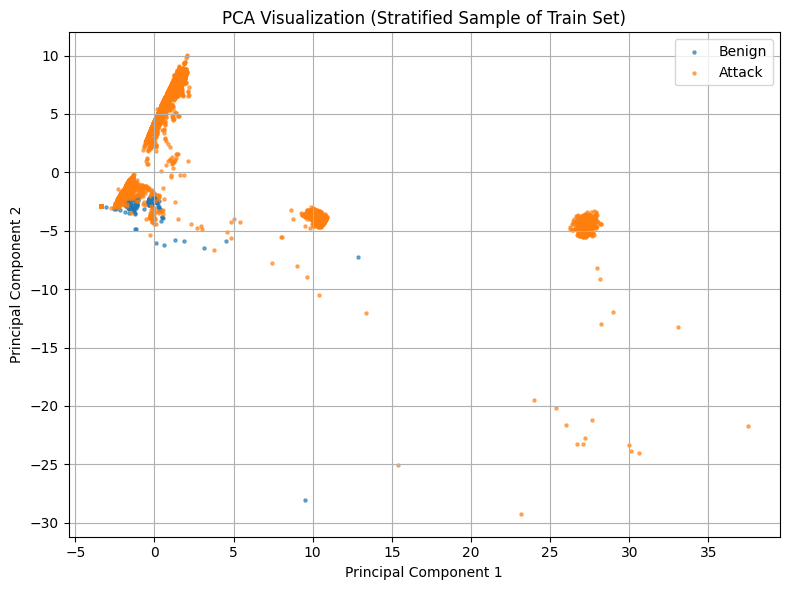

=== PCA Analysis Completed Successfully ===


In [ ]:
# ============================================
# PCA ANALYSIS WITH STRATIFIED SAMPLING (FIXED)
# ============================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("\n=== Starting PCA Analysis (Stratified Sampling) ===")

# -------------------------------
# SAFETY CHECK
# -------------------------------
assert len(train_df) > 0, "train_df is empty. PCA cannot be performed."

# -------------------------------
# STRATIFIED SAMPLE
# -------------------------------
def stratified_sample(df, label_col="is_attack", n_samples=20000, random_state=42):
    if len(df) <= n_samples:
        return df.copy()

    df_sample, _ = train_test_split(
        df,
        train_size=n_samples,
        stratify=df[label_col],
        random_state=random_state
    )
    return df_sample

train_sample = stratified_sample(train_df, n_samples=20000)

print("Stratified sample shape:", train_sample.shape)
print("Class ratio:\n", train_sample["is_attack"].value_counts(normalize=True))

# -------------------------------
# FEATURE SELECTION
# -------------------------------
numeric_cols = train_sample.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "is_attack"]

X = train_sample[numeric_cols]

# -------------------------------
# STANDARDIZATION
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# PCA
# -------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

train_sample["PC1"] = X_pca[:, 0]
train_sample["PC2"] = X_pca[:, 1]

print("Explained variance ratio:", pca.explained_variance_ratio_)

# -------------------------------
# PLOT
# -------------------------------
plt.figure(figsize=(8,6))

plt.scatter(
    train_sample.loc[train_sample["is_attack"] == 0, "PC1"],
    train_sample.loc[train_sample["is_attack"] == 0, "PC2"],
    s=5, alpha=0.6, label="Benign"
)

plt.scatter(
    train_sample.loc[train_sample["is_attack"] == 1, "PC1"],
    train_sample.loc[train_sample["is_attack"] == 1, "PC2"],
    s=5, alpha=0.6, label="Attack"
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization (Stratified Sample of Train Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("=== PCA Analysis Completed Successfully ===")


In [ ]:
# Binary label: 0 = benign, 1 = attack
for df in (train_df, test_df):
    df["is_attack"] = (df["attack_type"] != "benign").astype(int)

# Use only numeric columns as features
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Don't use the label itself as a feature
numeric_cols = [c for c in numeric_cols if c != "is_attack"]

print("Number of numeric features:", len(numeric_cols))

X_train = train_df[numeric_cols]
y_train = train_df["is_attack"]

X_test  = test_df[numeric_cols]
y_test  = test_df["is_attack"]

print("Train label distribution:\n", y_train.value_counts(normalize=True))
print("\nTest label distribution:\n", y_test.value_counts(normalize=True))


Number of numeric features: 115
Train label distribution:
 is_attack
1    0.83484
0    0.16516
Name: proportion, dtype: float64

Test label distribution:
 is_attack
1    0.54179
0    0.45821
Name: proportion, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd # Ensure pandas is imported if not already globally available

# Define POISON_LEVELS and create poisoned_datasets (moved from cell xaFAO9yICzkl)
POISON_LEVELS = {
    "P0": 0,
    "P1": 1,
    "P3": 3,
    "P5": 5,
    "P10": 10
}

def cumulative_poison_blocks(df, percentages, label_col="is_attack",
                             block_fraction=0.20, random_state=42):
    """
    Applies cumulative poisoning:
        P1  = 1%
        P3  = P1 + 2%
        P5  = P3 + 2%
        P10 = P5 + 5%
    on ONLY a selected 20% block.
    """
    np.random.seed(random_state)

    n = len(df)
    block_size = int(n * block_fraction)

    # Choose fixed poison block (same for P1, P3, P5, P10)
    start = random_state % (n - block_size)
    end   = start + block_size

    poison_block = df.iloc[start:end].copy()

    poisoned_versions = {}
    cumulative_flip = 0

    for level, pct in percentages.items():
        # print(f"\n=== Creating {level} ({pct}% cumulative) ===")

        # Calculate new flips excluding previous flips
        new_flip_pct = pct - cumulative_flip
        cumulative_flip = pct

        # Identify attack rows inside fixed block
        attack_idx = poison_block[poison_block[label_col] == 1].index
        k = int(len(attack_idx) * (new_flip_pct / 100))

        if k > 0:
            flip_idx = np.random.choice(attack_idx, size=k, replace=False)
            poison_block.loc[flip_idx, label_col] = 0

        # Create final dataset
        new_df = df.copy()
        new_df.iloc[start:end] = poison_block

        poisoned_versions[level] = new_df

        # print(f"Flipped {k} new rows for {level}. Total flip = {cumulative_flip}%")

    return poisoned_versions

# Assuming train_df is already defined from previous cells
poisoned_datasets = cumulative_poison_blocks(
    df=train_df,
    percentages=POISON_LEVELS,
    label_col="is_attack",
    block_fraction=0.20,
    random_state=42
)

def stratified_sample_for_pca(df, label_col="is_attack", n_samples=20000, random_state=42):
    """
    Stratified sampling helper function.
    """
    if len(df) <= n_samples:
        return df.copy()

    # Ensure there are enough samples in each class for stratification
    min_samples_per_class = df[label_col].value_counts().min()
    if min_samples_per_class == 0:
        # Handle cases where a class might be empty after poisoning
        return df.sample(n=min(n_samples, len(df)), random_state=random_state)

    # Calculate train_size based on the smaller of n_samples or 80% of min_samples_per_class
    # to ensure stratification works correctly if n_samples is too large for a minority class
    effective_train_size = min(n_samples, df[label_col].value_counts().sum())

    # If effective_train_size is 0, return an empty dataframe or handle as needed
    if effective_train_size == 0:
        return pd.DataFrame(columns=df.columns)

    # Adjust train_size if it's too large for stratification based on the smallest class
    if effective_train_size < 2 * df[label_col].nunique(): # Need at least 2 samples per class for stratify to work
        # Fallback to simple sampling if stratified is not possible with the requested size
        return df.sample(n=effective_train_size, random_state=random_state)

    df_sample, _ = train_test_split(
        df,
        train_size=effective_train_size,
        stratify=df[label_col],
        random_state=random_state
    )
    return df_sample

def run_pca_for_poison_level(df, level_name, n_samples=20000, random_state=42):
    """
    Performs PCA on a stratified sample of the given DataFrame and returns the
    explained variance ratios for the first two principal components.
    """
    # Use numeric_cols from the latest notebook state (from cell 0wxiQTQasoCh)
    feature_cols_for_pca = [
        c for c in df.columns
        if c != "is_attack" and np.issubdtype(df[c].dtype, np.number)
    ]

    sample = stratified_sample_for_pca(df, n_samples=n_samples, random_state=random_state)

    if sample.empty:
        print(f"Warning: Sample for {level_name} is empty, returning NaN for PCA.")
        return {"explained_variance_ratio": [np.nan, np.nan]}

    X = sample[feature_cols_for_pca]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca_2 = PCA(n_components=2, random_state=random_state)
    pca_2.fit(X_scaled)

    return {"explained_variance_ratio": pca_2.explained_variance_ratio_.tolist()}

pca_results = {}

for lvl in ["P0", "P1", "P3", "P5", "P10"]:
    pca_results[lvl] = run_pca_for_poison_level(
        poisoned_datasets[lvl],
        lvl
    )

In [ ]:
# ============================================
# PART 1 – BASELINE TRAINING (0% POISON, FIXED)
# ============================================

import time
import pandas as pd
import numpy as np

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

RANDOM_STATE = 42

# ---------------------------------------------------------
# 1) SELECT ONLY NUMERIC COLUMNS FOR FEATURES
# ---------------------------------------------------------
numeric_cols = [
    c for c in train_df.columns
    if c != "is_attack" and np.issubdtype(train_df[c].dtype, np.number)
]

print("Total columns in train_df:", len(train_df.columns))
print("Numeric feature columns  :", len(numeric_cols))

non_numeric = [
    c for c in train_df.columns
    if c != "is_attack" and not np.issubdtype(train_df[c].dtype, np.number)
]

print("Dropped NON-numeric columns (string/categorical):", non_numeric)

# ---------------------------------------------------------
# 2) MODEL FACTORY
# ---------------------------------------------------------
def make_models(random_state: int = RANDOM_STATE):
    models = {
        "Decision Tree (DT)": DecisionTreeClassifier(
            max_depth=None,
            min_samples_split=2,
            random_state=random_state
        ),

        "k-Nearest Neighbors (k-NN)": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier(
                n_neighbors=5,
                weights="distance",
                n_jobs=-1
            ))
        ]),

        "Random Forest (RF)": RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            class_weight="balanced",
            random_state=random_state,
            n_jobs=-1
        ),

        "Logistic Regression (LR)": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                n_jobs=-1
            ))
        ]),

        "XGBoost (XGB)": XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            n_jobs=-1,
            random_state=random_state
        )
    }
    return models


# ============================================
# PRINT MODEL HYPERPARAMETERS (DOCUMENTATION)
# ============================================

for name, model in make_models().items():
    print("\nModel:", name)
    print(model)



# ---------------------------------------------------------
# 3) TRAIN–TEST ARRAYS
# ---------------------------------------------------------
feature_cols = numeric_cols

X_train = train_df[feature_cols].values
y_train = train_df["is_attack"].values

X_test  = test_df[feature_cols].values
y_test  = test_df["is_attack"].values










# ---------------------------------------------------------
# 4) TRAIN BASELINE MODELS ON CLEAN DATA
# ---------------------------------------------------------
baseline_models = make_models(random_state=RANDOM_STATE)
baseline_results = []

print("\n================ BASELINE TRAINING ON CLEAN DATA ================")

for model_name, model in baseline_models.items():
    print(f"\n[BASELINE] Training model: {model_name}")

    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )

    # ROC–AUC
    try:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)
        else:
            y_proba = None

        roc = roc_auc_score(y_test, y_proba) if y_proba is not None else float("nan")
    except Exception:
        roc = float("nan")

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc:.4f}")
    print(f"Train time (s): {train_time:.2f}")

    baseline_results.append({
        "Model_Name": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Score": f1,
        "ROC_AUC": roc,
        "Train_Time_Sec": train_time
    })

# ---------------------------------------------------------
# 5) BASELINE RESULTS TABLE
# ---------------------------------------------------------
baseline_results_df = pd.DataFrame(baseline_results)

print("\n================ BASELINE SUMMARY =================")
print(baseline_results_df)

baseline_results_df.to_csv("baseline_results.csv", index=False)
print("\n[INFO] baseline_results.csv saved.")







Total columns in train_df: 119
Numeric feature columns  : 115
Dropped NON-numeric columns (string/categorical): ['device_id', 'device_name', 'attack_type']

Model: Decision Tree (DT)
DecisionTreeClassifier(random_state=42)

Model: k-Nearest Neighbors (k-NN)
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', KNeighborsClassifier(n_jobs=-1, weights='distance'))])

Model: Random Forest (RF)
RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

Model: Logistic Regression (LR)
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1))])

Model: XGBoost (XGB)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_ca

In [ ]:
# ================================
# FEATURE OPTIMIZATION USING RFE
# ================================

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Feature sizes to test
feature_sizes = [10, 30, 50, 70, len(feature_cols)]

rfe_results = []

# Base estimator
base_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

for k in feature_sizes:
    print(f"Running RFE with {k} features...")

    rfe = RFE(estimator=base_model, n_features_to_select=k)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)

    model = LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    )

    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)

    acc = accuracy_score(y_test, y_pred)

    rfe_results.append({
        "Num_Features": k,
        "Accuracy": acc
    })

# Convert to DataFrame
rfe_df = pd.DataFrame(rfe_results)

print("\n=== Feature vs Accuracy Table ===")
print(rfe_df)


Running RFE with 10 features...
Running RFE with 30 features...
Running RFE with 50 features...
Running RFE with 70 features...
Running RFE with 115 features...

=== Feature vs Accuracy Table ===
   Num_Features  Accuracy
0            10   0.71110
1            30   0.71108
2            50   0.71108
3            70   0.71108
4           115   0.71108


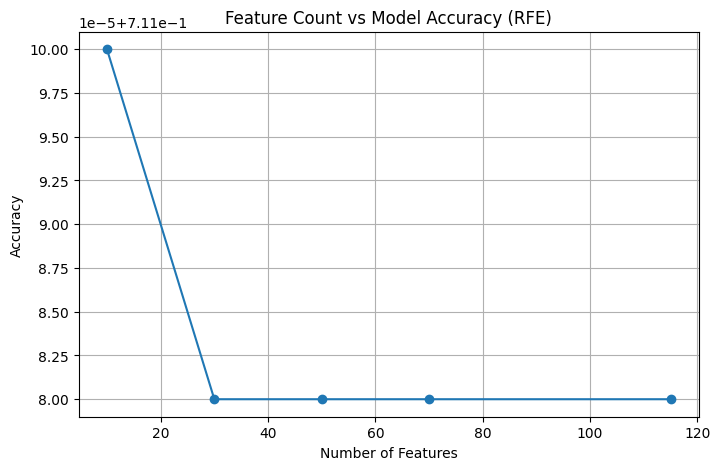

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(
    rfe_df["Num_Features"],
    rfe_df["Accuracy"],
    marker='o'
)

plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Feature Count vs Model Accuracy (RFE)")
plt.grid(True)
plt.show()


In [ ]:
# ============================================
# FEATURE IMPORTANCE USING RANDOM FOREST
# ============================================

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_model.fit(train_df[feature_cols], train_df["is_attack"])

importances = rf_model.feature_importances_

rf_importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

rf_top_features = rf_importance_df["feature"].tolist()

print("Top 10 important features:")
print(rf_top_features[:10])


Top 10 important features:
['HH_jit_L0.01_mean', 'H_L0.01_mean', 'HH_jit_L0.1_mean', 'HpHp_L0.01_weight', 'HH_L0.01_magnitude', 'HH_L0.01_mean', 'HH_L0.1_magnitude', 'MI_dir_L0.1_mean', 'MI_dir_L0.01_mean', 'HpHp_L0.1_weight']


In [ ]:
# ==============================
# FEATURE SET DEFINITIONS (AFTER IMPORTANCE)
# ==============================

features_all = feature_cols   # 115 features
TOP_K = 30
features_topk = rf_top_features[:TOP_K]

print("Total features (baseline):", len(features_all))
print("Total features (Top-K):", len(features_topk))


Total features (baseline): 115
Total features (Top-K): 30


In [ ]:
# ============================================
# BASELINE vs OPTIMIZED FEATURE COMPARISON
# ============================================

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time

def train_and_evaluate_simple(model, Xtr, ytr, Xts, yts):
    start = time.time()
    model.fit(Xtr, ytr)
    train_time = time.time() - start

    preds = model.predict(Xts)

    acc = accuracy_score(yts, preds)
    _, _, f1, _ = precision_recall_fscore_support(
        yts, preds, average="binary", zero_division=0
    )

    return acc, f1, train_time


comparison_results = []

# Use strong representative model
model_name = "XGBoost (XGB)"

baseline_model = make_models()[model_name]
opt_model      = make_models()[model_name]

# -------- Baseline (All features) --------
acc_all, f1_all, time_all = train_and_evaluate_simple(
    baseline_model,
    train_df[features_all],
    train_df["is_attack"],
    test_df[features_all],
    test_df["is_attack"]
)

comparison_results.append({
    "Feature_Set": "All Features (Baseline)",
    "Num_Features": len(features_all),
    "Accuracy": acc_all,
    "F1_Score": f1_all,
    "Train_Time_Sec": time_all
})

# -------- Optimized (Top-K = 30) --------
acc_opt, f1_opt, time_opt = train_and_evaluate_simple(
    opt_model,
    train_df[features_topk],
    train_df["is_attack"],
    test_df[features_topk],
    test_df["is_attack"]
)

comparison_results.append({
    "Feature_Set": "RF Top-30 Features",
    "Num_Features": len(features_topk),
    "Accuracy": acc_opt,
    "F1_Score": f1_opt,
    "Train_Time_Sec": time_opt
})

# Create comparison table
feature_opt_comparison_df = pd.DataFrame(comparison_results)

print("\n=== Baseline vs Optimized Feature Comparison ===")
print(feature_opt_comparison_df)

# Save for Word report
feature_opt_comparison_df.to_csv(
    "baseline_vs_optimized_features.csv",
    index=False
)



=== Baseline vs Optimized Feature Comparison ===
               Feature_Set  Num_Features  Accuracy  F1_Score  Train_Time_Sec
0  All Features (Baseline)           115   0.98130  0.983035       18.880071
1       RF Top-30 Features            30   0.88501  0.885810        8.212352


In [ ]:
feature_opt_comparison_df.to_csv(
    "feature_optimization_comparison.csv",
    index=False
)


In [ ]:
# ==============================
# FEATURE SELECTION (VARIANCE THRESHOLD)
# ==============================

from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_train_fs = selector.fit_transform(X_train)

selected_features = np.array(feature_cols)[selector.get_support()]
print("Original features:", len(feature_cols))
print("Selected features:", len(selected_features))


Original features: 115
Selected features: 105


In [ ]:
# ============================================
# FEATURE SELECTION USING RANDOM FOREST (P0)
# ============================================

from sklearn.ensemble import RandomForestClassifier

rf_fs = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_fs.fit(X_train, y_train)

importances = rf_fs.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_importance_df.to_csv("feature_importance_rf.csv", index=False)

print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))


# --------------------------------------------
# SELECT TOP-K FEATURES
# --------------------------------------------

TOP_K = 30
selected_features = feature_importance_df["Feature"].head(TOP_K).tolist()

print(f"\nSelected top {TOP_K} features for optimization.")


# ============================================
# MODEL PERFORMANCE WITH SELECTED FEATURES (P0)
# ============================================

xgb_fs = make_models()["XGBoost (XGB)"]

X_train_fs = train_df[selected_features].values
y_train_fs = train_df["is_attack"].values

X_test_fs = test_df[selected_features].values
y_test_fs = test_df["is_attack"].values

xgb_fs.fit(X_train_fs, y_train_fs)
pred_fs = xgb_fs.predict(X_test_fs)

acc_fs = accuracy_score(y_test_fs, pred_fs)
prec_fs, rec_fs, f1_fs, _ = precision_recall_fscore_support(
    y_test_fs, pred_fs, average="binary", zero_division=0
)

print("\nXGBoost with Selected Features (Clean Data):")
print("Accuracy :", round(acc_fs, 4))
print("Precision:", round(prec_fs, 4))
print("Recall   :", round(rec_fs, 4))
print("F1 Score :", round(f1_fs, 4))



Top 10 Important Features:
                Feature  Importance
78    HH_jit_L0.01_mean    0.102799
75     HH_jit_L0.1_mean    0.075208
108   HpHp_L0.01_weight    0.058059
59        HH_L0.01_mean    0.057020
61   HH_L0.01_magnitude    0.056219
54    HH_L0.1_magnitude    0.049491
112   HpHp_L0.01_radius    0.048234
28         H_L0.01_mean    0.047010
10     MI_dir_L0.1_mean    0.033592
13    MI_dir_L0.01_mean    0.032378

Selected top 30 features for optimization.

XGBoost with Selected Features (Clean Data):
Accuracy : 0.9244
Precision: 0.9621
Recall   : 0.8957
F1 Score : 0.9277


In [ ]:
# ============================================
# PCA EXPLAINED VARIANCE (STRATIFIED SAMPLE)
# ============================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

def run_pca_for_poison_level(df, level_name, n_samples=20000):
    print(f"\n--- PCA for {level_name} ---")

    # Stratified sampling
    df_sample, _ = train_test_split(
        df,
        train_size=n_samples,
        stratify=df["is_attack"],
        random_state=42
    )

    X = df_sample[feature_cols]
    y = df_sample["is_attack"]

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA (2 components)
    pca = PCA(n_components=2, random_state=42)
    pca.fit(X_scaled)

    pc1 = pca.explained_variance_ratio_[0] * 100
    pc2 = pca.explained_variance_ratio_[1] * 100
    total = pc1 + pc2

    print(f"PC1 Explained Variance (%): {pc1:.2f}")
    print(f"PC2 Explained Variance (%): {pc2:.2f}")
    print(f"Cumulative (PC1+PC2) (%): {total:.2f}")

    return pc1, pc2, total


In [ ]:
pca_results = {}

for lvl in ["P0", "P1", "P3", "P5", "P10"]:
    pca_results[lvl] = run_pca_for_poison_level(
        poisoned_datasets[lvl],
        lvl
    )



--- PCA for P0 ---
PC1 Explained Variance (%): 31.41
PC2 Explained Variance (%): 16.26
Cumulative (PC1+PC2) (%): 47.68

--- PCA for P1 ---
PC1 Explained Variance (%): 31.38
PC2 Explained Variance (%): 16.27
Cumulative (PC1+PC2) (%): 47.65

--- PCA for P3 ---
PC1 Explained Variance (%): 31.36
PC2 Explained Variance (%): 16.38
Cumulative (PC1+PC2) (%): 47.75

--- PCA for P5 ---
PC1 Explained Variance (%): 31.82
PC2 Explained Variance (%): 16.18
Cumulative (PC1+PC2) (%): 48.00

--- PCA for P10 ---
PC1 Explained Variance (%): 31.77
PC2 Explained Variance (%): 16.24
Cumulative (PC1+PC2) (%): 48.01


In [ ]:
pca_table = pd.DataFrame.from_dict(
    pca_results,
    orient="index",
    columns=["PC1 (%)", "PC2 (%)", "PC1+PC2 (%)"]
)

pca_table


,PC1 (%),PC2 (%),PC1+PC2 (%)
P0,31.413974,16.264444,47.678418
P1,31.383055,16.271227,47.654282
P3,31.362012,16.384678,47.746690
P5,31.816261,16.181457,47.997719
P10,31.771918,16.241206,48.013123


In [ ]:
pca_table.to_csv("pca_variance_across_poison_levels.csv")


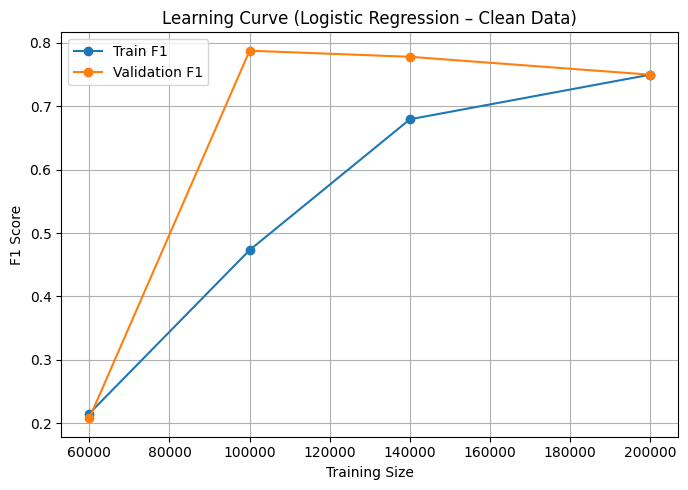

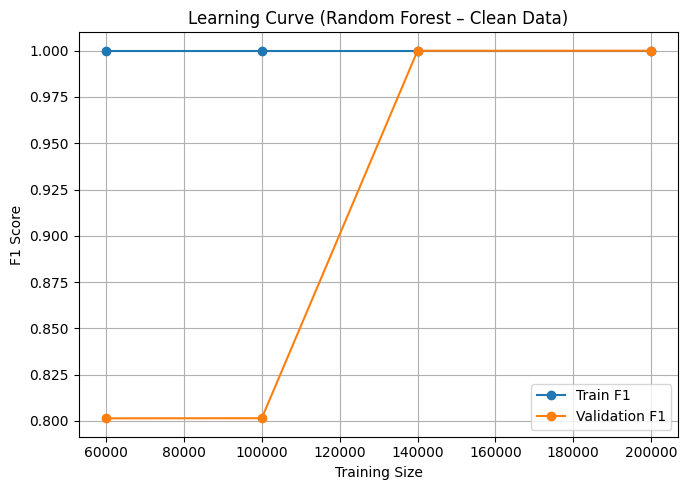

In [ ]:
# ============================================
# LEARNING CURVE (P0 – CLEAN DATA)
# ============================================

from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress expected warnings (optional)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train,
    y_train,
    train_sizes=[0.3, 0.5, 0.7, 1.0],   # IMPORTANT: avoid very small sizes
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    error_score=np.nan
)

# Remove rows where ALL folds failed
valid = ~np.isnan(test_scores).all(axis=1)

train_sizes = np.array(train_sizes)[valid]
train_scores = train_scores[valid]
test_scores = test_scores[valid]

plt.figure(figsize=(7,5))
plt.plot(train_sizes, np.nanmean(train_scores, axis=1), label="Train F1", marker="o")
plt.plot(train_sizes, np.nanmean(test_scores, axis=1), label="Validation F1", marker="o")
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve (Logistic Regression – Clean Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# ============================================
# LEARNING CURVE – RANDOM FOREST (CLEAN DATA)
# ============================================

from sklearn.model_selection import learning_curve, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

train_sizes, train_scores, test_scores = learning_curve(
    rf_model,
    X_train,
    y_train,
    train_sizes=[0.3, 0.5, 0.7, 1.0],
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    error_score=np.nan
)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, np.nanmean(train_scores, axis=1),
         label="Train F1", marker="o")
plt.plot(train_sizes, np.nanmean(test_scores, axis=1),
         label="Validation F1", marker="o")
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve (Random Forest – Clean Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# ============================================
# PART 2A — HELPER: CUMULATIVE POISONING (20% BLOCK FLIPPING)
# ============================================

def cumulative_poison_blocks(df, percentages, label_col="is_attack",
                             block_fraction=0.20, random_state=42):
    """
    Applies cumulative poisoning:
        P1  = 1%
        P3  = P1 + 2%
        P5  = P3 + 2%
        P10 = P5 + 5%
    on ONLY a selected 20% block.
    """
    np.random.seed(random_state)

    n = len(df)
    block_size = int(n * block_fraction)

    # Choose fixed poison block (same for P1, P3, P5, P10)
    start = random_state % (n - block_size)
    end   = start + block_size

    poison_block = df.iloc[start:end].copy()

    poisoned_versions = {}
    cumulative_flip = 0

    for level, pct in percentages.items():
        print(f"\n=== Creating {level} ({pct}% cumulative) ===")

        # Calculate new flips excluding previous flips
        new_flip_pct = pct - cumulative_flip
        cumulative_flip = pct

        # Identify attack rows inside fixed block
        attack_idx = poison_block[poison_block[label_col] == 1].index
        k = int(len(attack_idx) * (new_flip_pct / 100))

        if k > 0:
            flip_idx = np.random.choice(attack_idx, size=k, replace=False)
            poison_block.loc[flip_idx, label_col] = 0

        # Create final dataset
        new_df = df.copy()
        new_df.iloc[start:end] = poison_block

        poisoned_versions[level] = new_df

        print(f"Flipped {k} new rows for {level}. Total flip = {cumulative_flip}%")

    return poisoned_versions


In [ ]:
# ============================================
# PART 2B — CREATE POISONED DATASETS
# ============================================

POISON_LEVELS = {
    "P0": 0,
    "P1": 1,
    "P3": 3,
    "P5": 5,
    "P10": 10
}

poisoned_datasets = cumulative_poison_blocks(
    df=train_df,
    percentages=POISON_LEVELS,
    label_col="is_attack",
    block_fraction=0.20,
    random_state=42
)

print("\nREADY POISONED DATASETS:", list(poisoned_datasets.keys()))



=== Creating P0 (0% cumulative) ===
Flipped 0 new rows for P0. Total flip = 0%

=== Creating P1 (1% cumulative) ===
Flipped 104 new rows for P1. Total flip = 1%

=== Creating P3 (3% cumulative) ===
Flipped 207 new rows for P3. Total flip = 3%

=== Creating P5 (5% cumulative) ===
Flipped 203 new rows for P5. Total flip = 5%

=== Creating P10 (10% cumulative) ===
Flipped 499 new rows for P10. Total flip = 10%

READY POISONED DATASETS: ['P0', 'P1', 'P3', 'P5', 'P10']



=== PCA Analysis: Variance Explained + Poison Levels ===

--- PCA for P0 ---
Sample shape: (20000, 119)


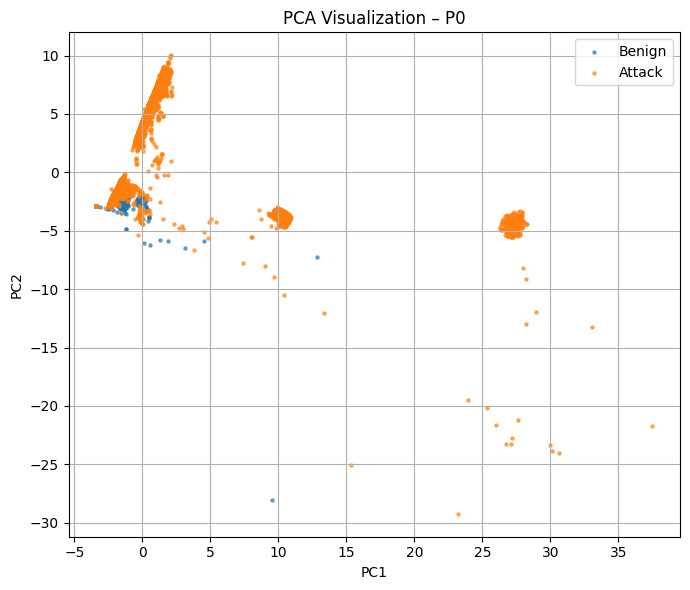

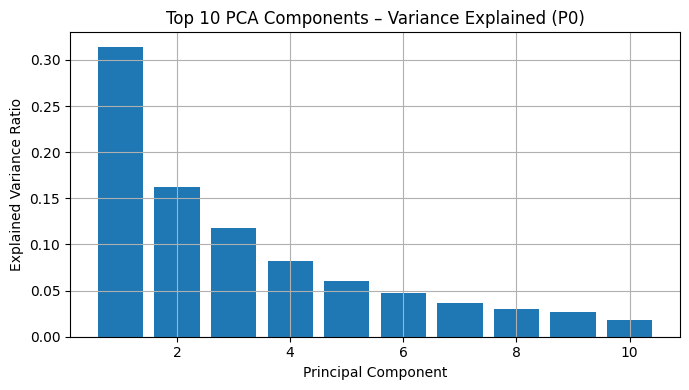

P0 explained variance (PC1, PC2): [0.31413974 0.16264444]

--- PCA for P1 ---
Sample shape: (20000, 119)


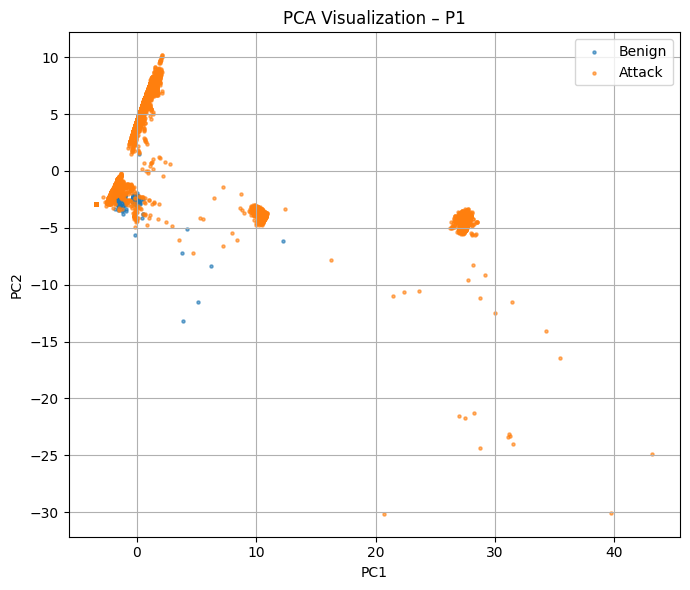

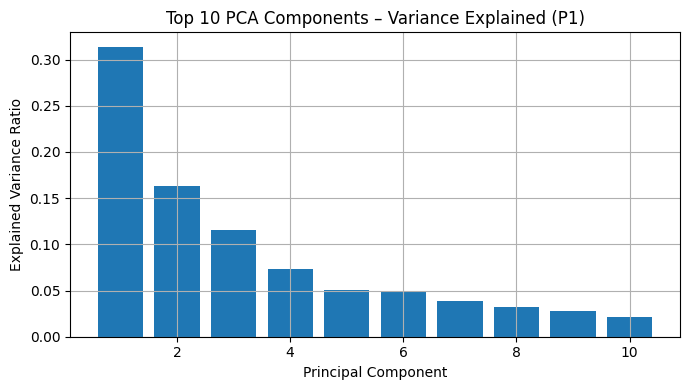

P1 explained variance (PC1, PC2): [0.31383055 0.16271227]

--- PCA for P3 ---
Sample shape: (20000, 119)


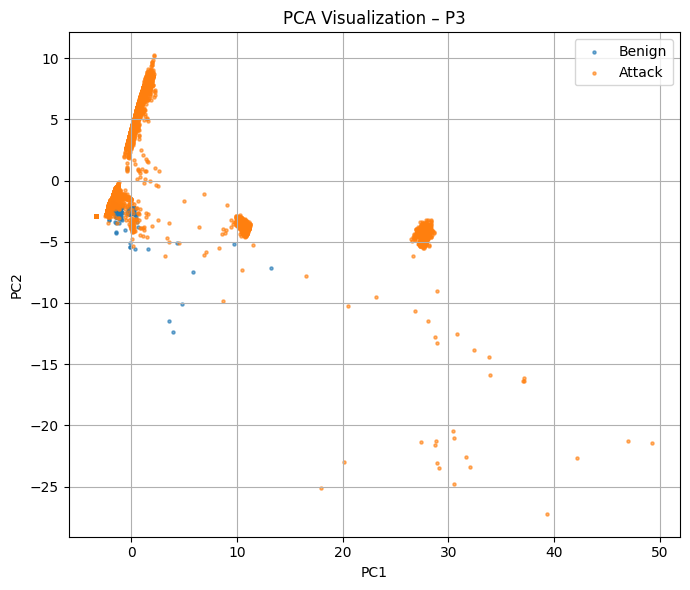

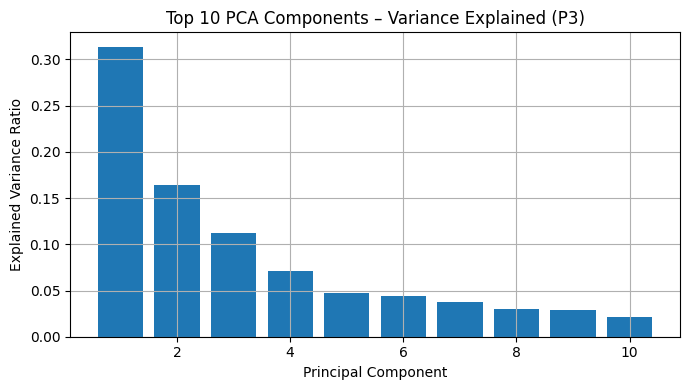

P3 explained variance (PC1, PC2): [0.31362012 0.16384678]

--- PCA for P5 ---
Sample shape: (20000, 119)


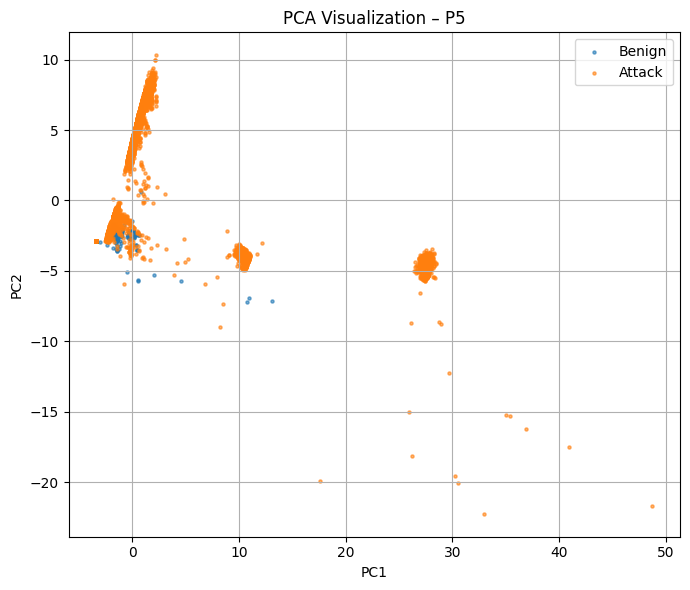

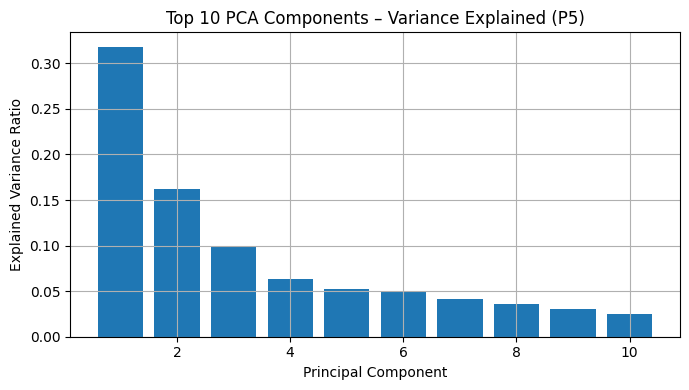

P5 explained variance (PC1, PC2): [0.31816261 0.16181457]

--- PCA for P10 ---
Sample shape: (20000, 119)


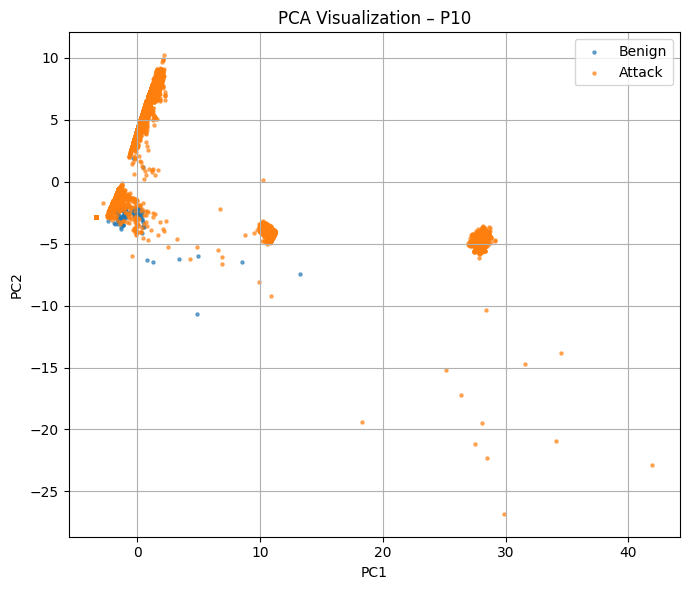

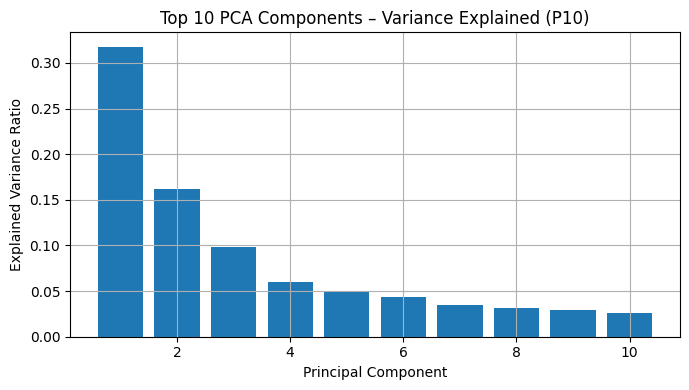

P10 explained variance (PC1, PC2): [0.31771918 0.16241206]

=== PCA Analysis for All Poison Levels Completed ===


In [ ]:
# ============================================
# PCA VARIANCE EXPLAINED + PCA FOR ALL POISON LEVELS
# ============================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

print("\n=== PCA Analysis: Variance Explained + Poison Levels ===")

# --------------------------------
# Stratified sampling helper
# --------------------------------
def stratified_sample(df, label_col="is_attack", n_samples=20000, random_state=42):
    if len(df) <= n_samples:
        return df.copy()

    df_sample, _ = train_test_split(
        df,
        train_size=n_samples,
        stratify=df[label_col],
        random_state=random_state
    )
    return df_sample

POISON_ORDER = ["P0", "P1", "P3", "P5", "P10"]

# --------------------------------
# PCA function with variance plot
# --------------------------------
def pca_with_variance_and_plot(df, level, n_samples=20000):

    print(f"\n--- PCA for {level} ---")

    # Stratified sample
    sample = stratified_sample(df, n_samples=n_samples)
    print("Sample shape:", sample.shape)

    # Numeric features
    numeric_cols = sample.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != "is_attack"]

    X = sample[numeric_cols]
    y = sample["is_attack"]

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # -------------------------------
    # PCA scatter (2 components)
    # -------------------------------
    pca_2 = PCA(n_components=2)
    X_pca = pca_2.fit_transform(X_scaled)

    sample["PC1"] = X_pca[:, 0]
    sample["PC2"] = X_pca[:, 1]

    plt.figure(figsize=(7, 6))
    plt.scatter(
        sample.loc[y == 0, "PC1"],
        sample.loc[y == 0, "PC2"],
        s=5, alpha=0.6, label="Benign"
    )
    plt.scatter(
        sample.loc[y == 1, "PC1"],
        sample.loc[y == 1, "PC2"],
        s=5, alpha=0.6, label="Attack"
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA Visualization – {level}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # PCA variance explained plot
    # -------------------------------
    pca_full = PCA()
    pca_full.fit(X_scaled)

    explained_var = pca_full.explained_variance_ratio_

    plt.figure(figsize=(7, 4))
    plt.bar(range(1, 11), explained_var[:10])
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title(f"Top 10 PCA Components – Variance Explained ({level})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{level} explained variance (PC1, PC2):", pca_2.explained_variance_ratio_)


# --------------------------------
# RUN PCA FOR ALL POISON LEVELS
# --------------------------------
for lvl in POISON_ORDER:
    pca_with_variance_and_plot(
        poisoned_datasets[lvl],
        level=lvl,
        n_samples=20000
    )

print("\n=== PCA Analysis for All Poison Levels Completed ===")


In [ ]:
# ============================================
# PART 2C — MANUAL TRAINING WITHOUT LOOPS
# ============================================

def train_single_model(model, train_df, test_df, model_name):
    Xtr = train_df[feature_cols].values
    ytr = train_df["is_attack"].values
    Xts = test_df[feature_cols].values
    yts = test_df["is_attack"].values

    print(f"\nTraining {model_name} ...")
    start = time.time()
    model.fit(Xtr, ytr)
    train_time = time.time() - start

    preds = model.predict(Xts)

    acc = accuracy_score(yts, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        yts, preds, average="binary", zero_division=0
    )

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Train_Time": train_time
    }

# ============================================
# PART 3 — MANUAL EXPERIMENT
# ============================================

all_results = []

for model_name, base_model in make_models().items():
    print("\n==============================")
    print(f"  MODEL: {model_name}")
    print("==============================")

    # P0 → fresh model
    results_p0 = train_single_model(
        make_models()[model_name], poisoned_datasets["P0"], test_df, f"{model_name} - P0"
    )
    all_results.append(results_p0)

    # P1
    results_p1 = train_single_model(
        make_models()[model_name], poisoned_datasets["P1"], test_df, f"{model_name} - P1"
    )
    all_results.append(results_p1)

    # P3
    results_p3 = train_single_model(
        make_models()[model_name], poisoned_datasets["P3"], test_df, f"{model_name} - P3"
    )
    all_results.append(results_p3)

    # P5
    results_p5 = train_single_model(
        make_models()[model_name], poisoned_datasets["P5"], test_df, f"{model_name} - P5"
    )
    all_results.append(results_p5)

    # P10
    results_p10 = train_single_model(
        make_models()[model_name], poisoned_datasets["P10"], test_df, f"{model_name} - P10"
    )
    all_results.append(results_p10)








  MODEL: Decision Tree (DT)

Training Decision Tree (DT) - P0 ...

Training Decision Tree (DT) - P1 ...

Training Decision Tree (DT) - P3 ...

Training Decision Tree (DT) - P5 ...

Training Decision Tree (DT) - P10 ...

  MODEL: k-Nearest Neighbors (k-NN)

Training k-Nearest Neighbors (k-NN) - P0 ...

Training k-Nearest Neighbors (k-NN) - P1 ...

Training k-Nearest Neighbors (k-NN) - P3 ...

Training k-Nearest Neighbors (k-NN) - P5 ...

Training k-Nearest Neighbors (k-NN) - P10 ...

  MODEL: Random Forest (RF)

Training Random Forest (RF) - P0 ...

Training Random Forest (RF) - P1 ...

Training Random Forest (RF) - P3 ...

Training Random Forest (RF) - P5 ...

Training Random Forest (RF) - P10 ...

  MODEL: Logistic Regression (LR)

Training Logistic Regression (LR) - P0 ...

Training Logistic Regression (LR) - P1 ...

Training Logistic Regression (LR) - P3 ...

Training Logistic Regression (LR) - P5 ...

Training Logistic Regression (LR) - P10 ...

  MODEL: XGBoost (XGB)

Training XG

In [ ]:
# ============================================
# MISCLASSIFICATION ANALYSIS (P0 vs P10)
# ============================================

xgb_model = make_models()["XGBoost (XGB)"]

# ---------- P0 vs P10 ----------
xgb_model.fit(
    poisoned_datasets["P0"][feature_cols],
    poisoned_datasets["P0"]["is_attack"]
)
pred_p0 = xgb_model.predict(X_test)

xgb_model.fit(
    poisoned_datasets["P10"][feature_cols],
    poisoned_datasets["P10"]["is_attack"]
)
pred_p10 = xgb_model.predict(X_test)

mis_p0 = set(np.where(pred_p0 != y_test)[0])
mis_p10 = set(np.where(pred_p10 != y_test)[0])

print("\n[P0 vs P10 Misclassification]")
print("Misclassified samples in P0 :", len(mis_p0))
print("Misclassified samples in P10:", len(mis_p10))
print("Common misclassified        :", len(mis_p0 & mis_p10))
print("New errors due to poisoning :", len(mis_p10 - mis_p0))







# ============================================
# MISCLASSIFICATION CONSISTENCY ACROSS ALL POISON LEVELS
# ============================================

misclassified = {}

for lvl in ["P0", "P1", "P3", "P5", "P10"]:
    xgb_model.fit(
        poisoned_datasets[lvl][feature_cols],
        poisoned_datasets[lvl]["is_attack"]
    )
    preds = xgb_model.predict(X_test)
    misclassified[lvl] = set(np.where(preds != y_test)[0])

# Samples misclassified at ALL poison levels
common_all = set.intersection(*misclassified.values())
print("\nConsistently misclassified across ALL levels:", len(common_all))

# New misclassifications introduced at higher poison levels
for lvl in ["P1", "P3", "P5", "P10"]:
    new_errors = misclassified[lvl] - misclassified["P0"]
    print(f"New misclassifications at {lvl}:", len(new_errors))




final_results = pd.DataFrame(all_results)
final_results

In [ ]:
print("Total rows in final_results:", len(final_results))
print("\nUnique models:")
print(final_results["Model"].unique())

NameError: name 'final_results' is not defined

In [ ]:
display(final_results)

,Model,Accuracy,Precision,Recall,F1,Train_Time
0,Decision Tree (DT) - P0,0.88242,0.959271,0.817697,0.882844,26.666752
1,Decision Tree (DT) - P1,0.88296,0.960593,0.817512,0.883296,33.169696
2,Decision Tree (DT) - P3,0.88231,0.959241,0.817512,0.882724,41.844905
3,Decision Tree (DT) - P5,0.88208,0.960238,0.816146,0.882348,46.604616
4,Decision Tree (DT) - P10,0.88213,0.960342,0.816146,0.882392,40.688612
5,k-Nearest Neighbors (k-NN) - P0,0.93815,0.898000,0.999354,0.945970,1.046612
6,k-Nearest Neighbors (k-NN) - P1,0.93815,0.898000,0.999354,0.945970,0.672970
7,k-Nearest Neighbors (k-NN) - P3,0.93815,0.898000,0.999354,0.945970,0.981075
8,k-Nearest Neighbors (k-NN) - P5,0.93815,0.898000,0.999354,0.945970,0.669510
9,k-Nearest Neighbors (k-NN) - P10,0.93820,0.898101,0.999317,0.946009,0.652707


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Directly modify final_results DataFrame

# 1) Extract Poison_Level (P10 first for correct regex matching)
final_results["Poison_Level"] = final_results["Model"].str.extract(r'(P10|P5|P3|P1|P0)')

# 2) Clean Model_Name
final_results["Model_Name"] = final_results["Model"].str.replace(
    r'\s*-\s*(P10|P5|P3|P1|P0)', '', regex=True
)

# 3) Set order for Poison_Level
level_order = ["P0", "P1", "P3", "P5", "P10"]
final_results["Poison_Level"] = pd.Categorical(final_results["Poison_Level"],
                                         categories=level_order,
                                         ordered=True)

print(final_results)

                               Model  Accuracy  Precision    Recall        F1  \
0            Decision Tree (DT) - P0   0.88242   0.959271  0.817697  0.882844   
1            Decision Tree (DT) - P1   0.88296   0.960593  0.817512  0.883296   
2            Decision Tree (DT) - P3   0.88231   0.959241  0.817512  0.882724   
3            Decision Tree (DT) - P5   0.88208   0.960238  0.816146  0.882348   
4           Decision Tree (DT) - P10   0.88213   0.960342  0.816146  0.882392   
5    k-Nearest Neighbors (k-NN) - P0   0.93815   0.898000  0.999354  0.945970   
6    k-Nearest Neighbors (k-NN) - P1   0.93815   0.898000  0.999354  0.945970   
7    k-Nearest Neighbors (k-NN) - P3   0.93815   0.898000  0.999354  0.945970   
8    k-Nearest Neighbors (k-NN) - P5   0.93815   0.898000  0.999354  0.945970   
9   k-Nearest Neighbors (k-NN) - P10   0.93820   0.898101  0.999317  0.946009   
10           Random Forest (RF) - P0   0.91342   0.862226  0.999982  0.926009   
11           Random Forest (

In [ ]:
# Extract model name and poison level correctly
final_results["Base_Model"] = final_results["Model"].str.replace(r" - P\d+", "", regex=True)
final_results["Poison"] = final_results["Model"].str.extract(r"(P\d+)")


In [ ]:
accuracy_table = final_results.pivot(
    index="Base_Model",
    columns="Poison",
    values="Accuracy"
)

accuracy_table = accuracy_table[["P0", "P1", "P3", "P5", "P10"]]

display(accuracy_table)


Poison,P0,P1,P3,P5,P10
Base_Model,,,,,
Decision Tree (DT),0.88242,0.88296,0.88231,0.88208,0.88213
Logistic Regression (LR),0.92464,0.92459,0.93744,0.94342,0.94336
Random Forest (RF),0.91342,0.87197,0.86360,0.84209,0.84212
XGBoost (XGB),0.98130,0.98099,0.98069,0.98071,0.98126
k-Nearest Neighbors (k-NN),0.93815,0.93815,0.93815,0.93815,0.93820


In [ ]:
precision_table = final_results.pivot(
    index="Base_Model",
    columns="Poison",
    values="Precision"
)[["P0", "P1", "P3", "P5", "P10"]]

display(precision_table)




Poison,P0,P1,P3,P5,P10
Base_Model,,,,,
Decision Tree (DT),0.959271,0.960593,0.959241,0.960238,0.960342
Logistic Regression (LR),0.918000,0.955325,0.951261,0.952663,0.944138
Random Forest (RF),0.862226,0.808887,0.798885,0.774325,0.774351
XGBoost (XGB),0.966670,0.966168,0.965652,0.965686,0.966617
k-Nearest Neighbors (k-NN),0.898000,0.898000,0.898000,0.898000,0.898101


In [ ]:
recall_table = final_results.pivot(
    index="Base_Model",
    columns="Poison",
    values="Recall"
)[["P0", "P1", "P3", "P5", "P10"]]


display(recall_table)

Poison,P0,P1,P3,P5,P10
Base_Model,,,,,
Decision Tree (DT),0.817697,0.817512,0.817512,0.816146,0.816146
Logistic Regression (LR),0.945348,0.903044,0.932298,0.942395,0.951771
Random Forest (RF),0.999982,0.999945,0.999982,0.999982,1.000000
XGBoost (XGB),0.999963,0.999926,0.999926,0.999926,0.999945
k-Nearest Neighbors (k-NN),0.999354,0.999354,0.999354,0.999354,0.999317


In [ ]:
f1_table = final_results.pivot(
    index="Base_Model",
    columns="Poison",
    values="F1"
)[["P0", "P1", "P3", "P5", "P10"]]
display(f1_table)

Poison,P0,P1,P3,P5,P10
Base_Model,,,,,
Decision Tree (DT),0.882844,0.883296,0.882724,0.882348,0.882392
Logistic Regression (LR),0.931473,0.928449,0.941684,0.947501,0.947939
Random Forest (RF),0.926009,0.894325,0.888193,0.872804,0.872827
XGBoost (XGB),0.983035,0.982758,0.982490,0.982508,0.982999
k-Nearest Neighbors (k-NN),0.945970,0.945970,0.945970,0.945970,0.946009


In [ ]:
print(final_results.columns.tolist())


['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'Train_Time', 'Poison_Level', 'Model_Name', 'Base_Model', 'Poison']


In [ ]:
train_time_table = final_results.pivot(
    index="Base_Model",
    columns="Poison",
    values="Train_Time"
)

# Order poison levels
train_time_table = train_time_table[["P0", "P1", "P3", "P5", "P10"]]

display(train_time_table)


Poison,P0,P1,P3,P5,P10
Base_Model,,,,,
Decision Tree (DT),26.666752,33.169696,41.844905,46.604616,40.688612
Logistic Regression (LR),11.062260,9.099585,9.767451,11.313331,8.288556
Random Forest (RF),211.870993,277.371275,271.926082,260.971205,264.910325
XGBoost (XGB),25.201351,32.306792,33.343273,34.761782,32.897246
k-Nearest Neighbors (k-NN),1.046612,0.672970,0.981075,0.669510,0.652707


In [ ]:
# ============================================================
# MISCLASSIFICATION TRANSITION ANALYSIS (LEVEL TO LEVEL)
# ============================================================

print("\n=== Misclassification Changes Between Poison Levels ===")

poison_levels = ["P0", "P1", "P3", "P5", "P10"]

misclassification_changes = []

for i in range(len(poison_levels) - 1):
    prev_lvl = poison_levels[i]
    next_lvl = poison_levels[i + 1]

    prev_set = misclassified[prev_lvl]
    next_set = misclassified[next_lvl]

    newly_misclassified = next_set - prev_set
    corrected = prev_set - next_set

    misclassification_changes.append({
        "From": f"{prev_lvl} → {next_lvl}",
        "New_Misclassified": len(newly_misclassified),
        "Corrected": len(corrected),
        "Net_Change": len(newly_misclassified) - len(corrected)
    })

    print(f"\n{prev_lvl} → {next_lvl}")
    print(f"New misclassifications: {len(newly_misclassified)}")
    print(f"Corrected samples: {len(corrected)}")
    print(f"Net change: {len(newly_misclassified) - len(corrected)}")

# Convert to DataFrame for report
misclassification_transition_df = pd.DataFrame(misclassification_changes)
print("\n=== Misclassification Transition Table ===")
display(misclassification_transition_df)



=== Misclassification Changes Between Poison Levels ===

P0 → P1
New misclassifications: 64
Corrected samples: 33
Net change: 31

P1 → P3
New misclassifications: 46
Corrected samples: 16
Net change: 30

P3 → P5
New misclassifications: 25
Corrected samples: 27
Net change: -2

P5 → P10
New misclassifications: 11
Corrected samples: 66
Net change: -55

=== Misclassification Transition Table ===


,From,New_Misclassified,Corrected,Net_Change
0,P0 → P1,64,33,31
1,P1 → P3,46,16,30
2,P3 → P5,25,27,-2
3,P5 → P10,11,66,-55


In [ ]:
f1_p0 = final_results[final_results["Poison_Level"] == "P0"][["Model_Name", "F1"]].rename(columns={"F1": "F1_at_P0"})
f1_p10 = final_results[final_results["Poison_Level"] == "P10"][["Model_Name", "F1"]].rename(columns={"F1": "F1_at_P10"})

In [ ]:
f1_merged = pd.merge(f1_p0, f1_p10, on="Model_Name")


In [ ]:
f1_merged["F1_Abs_Drop"] = f1_merged["F1_at_P0"] - f1_merged["F1_at_P10"]
f1_merged["F1_Rel_Drop_%"] = (f1_merged["F1_Abs_Drop"] / f1_merged["F1_at_P0"]) * 100

f1_merged_round = f1_merged.round(4)
print(f1_merged_round)


                   Model_Name  F1_at_P0  F1_at_P10  F1_Abs_Drop  F1_Rel_Drop_%
0          Decision Tree (DT)    0.8828     0.8824       0.0005         0.0512
1  k-Nearest Neighbors (k-NN)    0.9460     0.9460      -0.0000        -0.0042
2          Random Forest (RF)    0.9260     0.8728       0.0532         5.7431
3    Logistic Regression (LR)    0.9315     0.9479      -0.0165        -1.7677
4               XGBoost (XGB)    0.9830     0.9830       0.0000         0.0037


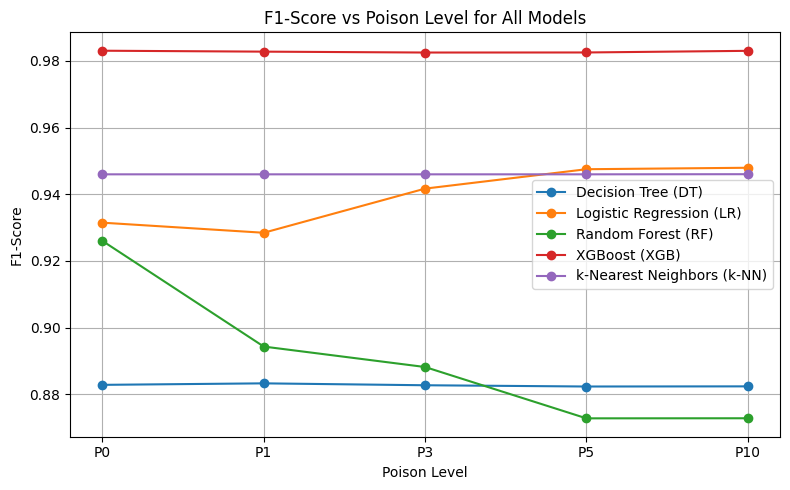

In [ ]:
import matplotlib.pyplot as plt

level_order = ["P0", "P1", "P3", "P5", "P10"]

plt.figure(figsize=(8, 5))

for model_name, group in final_results.groupby("Model_Name"):
    group_sorted = group.sort_values("Poison_Level")
    plt.plot(
        group_sorted["Poison_Level"],
        group_sorted["F1"],
        marker="o",
        label=model_name
    )

plt.xlabel("Poison Level")
plt.ylabel("F1-Score")
plt.title("F1-Score vs Poison Level for All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

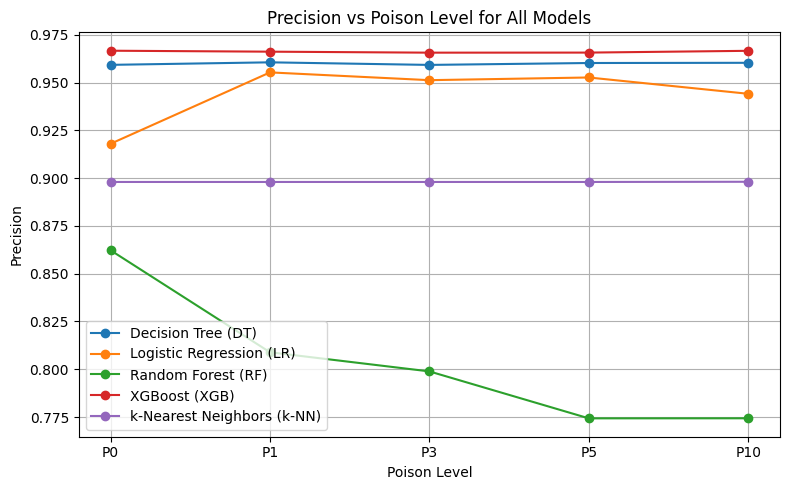

In [ ]:
plt.figure(figsize=(8, 5))

for model_name, group in final_results.groupby("Model_Name"):
    group_sorted = group.sort_values("Poison_Level")
    plt.plot(
        group_sorted["Poison_Level"],
        group_sorted["Precision"],
        marker="o",
        label=model_name
    )

plt.xlabel("Poison Level")
plt.ylabel("Precision")
plt.title("Precision vs Poison Level for All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

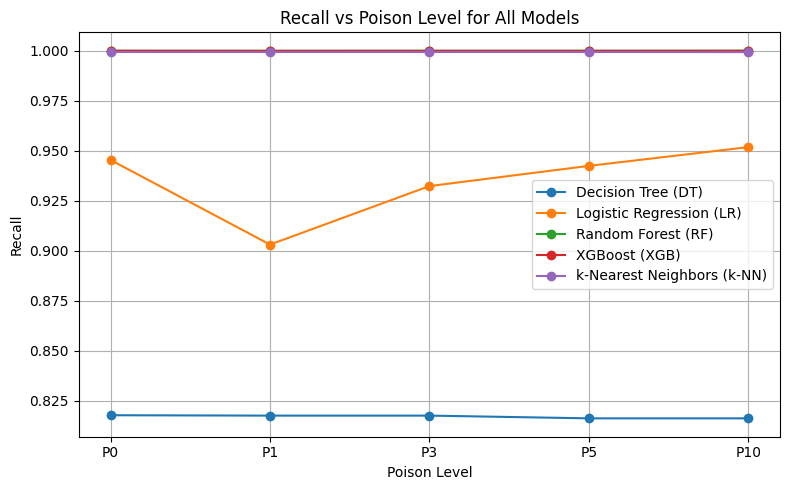

In [ ]:
plt.figure(figsize=(8, 5))

for model_name, group in final_results.groupby("Model_Name"):
    group_sorted = group.sort_values("Poison_Level")
    plt.plot(
        group_sorted["Poison_Level"],
        group_sorted["Recall"],
        marker="o",
        label=model_name
    )

plt.xlabel("Poison Level")
plt.ylabel("Recall")
plt.title("Recall vs Poison Level for All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Only P0 and P10
f1_p0 = final_results[final_results["Poison_Level"] == "P0"][["Model_Name", "F1"]].rename(columns={"F1": "F1_at_0"})
f1_p10 = final_results[final_results["Poison_Level"] == "P10"][["Model_Name", "F1"]].rename(columns={"F1": "F1_at_10"})

f1_merged = pd.merge(f1_p0, f1_p10, on="Model_Name")

f1_merged["F1_Abs_Drop"]   = f1_merged["F1_at_0"] - f1_merged["F1_at_10"]
f1_merged["F1_Rel_Drop_%"] = (f1_merged["F1_Abs_Drop"] / f1_merged["F1_at_0"]) * 100

f1_merged_round = f1_merged.copy()
f1_merged_round[["F1_at_0", "F1_at_10", "F1_Abs_Drop", "F1_Rel_Drop_%"]] = \
    f1_merged_round[["F1_at_0", "F1_at_10", "F1_Abs_Drop", "F1_Rel_Drop_%"]].round(4)

print(f1_merged_round)

                   Model_Name  F1_at_0  F1_at_10  F1_Abs_Drop  F1_Rel_Drop_%
0          Decision Tree (DT)   0.8828    0.8824       0.0005         0.0512
1  k-Nearest Neighbors (k-NN)   0.9460    0.9460      -0.0000        -0.0042
2          Random Forest (RF)   0.9260    0.8728       0.0532         5.7431
3    Logistic Regression (LR)   0.9315    0.9479      -0.0165        -1.7677
4               XGBoost (XGB)   0.9830    0.9830       0.0000         0.0037


In [ ]:
for lvl, df in poisoned_datasets.items():
    print(lvl, df["is_attack"].value_counts())


P0 is_attack
1    250452
0     49548
Name: count, dtype: int64
P1 is_attack
1    250348
0     49652
Name: count, dtype: int64
P3 is_attack
1    250141
0     49859
Name: count, dtype: int64
P5 is_attack
1    249938
0     50062
Name: count, dtype: int64
P10 is_attack
1    249439
0     50561
Name: count, dtype: int64


In [ ]:
test_df["is_attack"].value_counts()


,count
is_attack,
1,54179
0,45821


In [ ]:
len(final_results)

25

In [ ]:
final_results["Model_Name"].value_counts()

,count
Model_Name,
Decision Tree (DT),5
k-Nearest Neighbors (k-NN),5
Random Forest (RF),5
Logistic Regression (LR),5
XGBoost (XGB),5


In [ ]:
import pyarrow.parquet as pq

def get_parquet_info(path):
    pf = pq.ParquetFile(path)
    num_rows = pf.metadata.num_rows
    num_cols = len(pf.schema.names)
    col_names = pf.schema.names
    return num_rows, num_cols, col_names

train_path = "/content/train_nbaiot.parquet"
test_path  = "/content/test_nbaiot.parquet"

train_rows, train_cols, train_colnames = get_parquet_info(train_path)
test_rows, test_cols, test_colnames   = get_parquet_info(test_path)

print("===== TRAIN FILE INFO =====")
print("Rows:", train_rows)
print("Columns:", train_cols)
print("Column names:", train_colnames)

print("\n===== TEST FILE INFO =====")
print("Rows:", test_rows)
print("Columns:", test_cols)
print("Column names:", test_colnames)


===== TRAIN FILE INFO =====
Rows: 5650085
Columns: 119
Column names: ['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance', 'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance', 'MI_dir_L0.1_weight', 'MI_dir_L0.1_mean', 'MI_dir_L0.1_variance', 'MI_dir_L0.01_weight', 'MI_dir_L0.01_mean', 'MI_dir_L0.01_variance', 'H_L5_weight', 'H_L5_mean', 'H_L5_variance', 'H_L3_weight', 'H_L3_mean', 'H_L3_variance', 'H_L1_weight', 'H_L1_mean', 'H_L1_variance', 'H_L0.1_weight', 'H_L0.1_mean', 'H_L0.1_variance', 'H_L0.01_weight', 'H_L0.01_mean', 'H_L0.01_variance', 'HH_L5_weight', 'HH_L5_mean', 'HH_L5_std', 'HH_L5_magnitude', 'HH_L5_radius', 'HH_L5_covariance', 'HH_L5_pcc', 'HH_L3_weight', 'HH_L3_mean', 'HH_L3_std', 'HH_L3_magnitude', 'HH_L3_radius', 'HH_L3_covariance', 'HH_L3_pcc', 'HH_L1_weight', 'HH_L1_mean', 'HH_L1_std', 'HH_L1_magnitude', 'HH_L1_radius', 'HH_L1_covariance', 'HH_L1_pcc', 'HH_L0.1_weight', 'HH_L0.1_mean', 'HH_L0.1